In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/kaggle/FiQA_ABSA_task1/ .
!cp -r /content/drive/MyDrive/kaggle/FinancialPhraseBank-v1.0/ .

In [ ]:
base_path = "path where the dataset gets downloaded"
import json
fp = open(base_path+'/FiQA_ABSA_task1/task1_headline_ABSA_train.json', 'r')
data = json.load(fp)

In [ ]:
!wget https://zenodo.org/record/5524358/files/edgar-w2v-200d.zip
!unzip edgar-w2v-200d.zip

--2022-03-02 19:17:47--  https://zenodo.org/record/5524358/files/edgar-w2v-200d.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75422551 (72M) [application/octet-stream]
Saving to: ‘edgar-w2v-200d.zip’

edgar-w2v-200d.zip  100%[===================>]  71.93M  19.9MB/s    in 3.8s    

2022-03-02 19:17:52 (18.8 MB/s) - ‘edgar-w2v-200d.zip’ saved [75422551/75422551]

Archive:  edgar-w2v-200d.zip
  inflating: edgar.word.w2v.200.bin  
  inflating: edgar.word.w2v.200.vocab  


# Training LSTM

In [ ]:
!pip install gensim -q

In [ ]:
from gensim.models import KeyedVectors

w2v = KeyedVectors.load_word2vec_format(base_path + '/edgar.word.w2v.200.bin', binary=True)

In [ ]:
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')

stemmer = nltk.stem.PorterStemmer()
stopwords = set(nltk.corpus.stopwords.words('english'))
  
def clean_text(text):
  text = text.lower()
  text = re.sub(r"[^0-9a-z]", " ", text)

  words = nltk.tokenize.word_tokenize(text)
  token = list(map(lambda x: stemmer.stem(x), words))
  token = list(filter(lambda x: (x not in stopwords) and (x in w2v), token))
  return ' '.join(token)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding, Flatten, MaxPool1D

In [ ]:
input_length = 20

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_length = 100002
Embedding_dimensions = w2v.vectors.shape[1]

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(w2v.index2word)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
  if word in w2v:
      embedding_matrix[token] = w2v[word]

Tokenizer vocab length: 100002


In [ ]:
from pprint import pprint
X, y = [], []

sent2num = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}

with open(base_path + '/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt', 
          mode='r', 
          encoding='ISO-8859-1') as f:
  for line in f.readlines():
    line = line.strip()
    X.append(line.split('@')[0])
    y.append(sent2num[line.split('@')[1]])

with open(base_path + '/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_75Agree.txt', 
          mode='r', 
          encoding='ISO-8859-1') as f:
  for line in f.readlines():
    line = line.strip()
    X.append(line.split('@')[0])
    y.append(sent2num[line.split('@')[1]])

with open(base_path + '/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_66Agree.txt', 
          mode='r', 
          encoding='ISO-8859-1') as f:
  for line in f.readlines():
    line = line.strip()
    X.append(line.split('@')[0])
    y.append(sent2num[line.split('@')[1]])

with open(base_path + '/FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_50Agree.txt', 
          mode='r', 
          encoding='ISO-8859-1') as f:
  for line in f.readlines():
    line = line.strip()
    X.append(line.split('@')[0])
    y.append(sent2num[line.split('@')[1]])

In [ ]:
X, y = [], []

with open(base_path + '/FiQA_ABSA_task1/task1_headline_ABSA_train.json', 'r') as f:
  data = json.load(f)
  for i in data:
    X.append(data[i]['sentence'])
    y.append(float(data[i]['info'][0]['sentiment_score']))

with open(base_path + '/FiQA_ABSA_task1/task1_post_ABSA_train.json', 'r') as f:
  data = json.load(f)
  for i in data:
    X.append(data[i]['sentence'])
    y.append(float(data[i]['info'][0]['sentiment_score']))

X = np.array(X)
y = np.array(y)

In [ ]:
X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=input_length)
print(X.shape)

(14780, 20)


In [ ]:
import pandas as pd

py = y
y = pd.get_dummies(y).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(128, dropout=0.1, return_sequences=True)),
        Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)),
        Conv1D(100, 3, activation='relu'),
        MaxPool1D(),
        Conv1D(12, 3, activation='relu'),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(3, activation='softmax'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
model = getModel()
model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 20, 200)           20000400  
                                                                 
 bidirectional_15 (Bidirecti  (None, 20, 256)          336896    
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 20, 128)          164352    
 onal)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 18, 100)           38500     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 100)           0         
 1D)                                                             
                                                   

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=2, cooldown=1),
             EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=4)]

# model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[])
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
582/582 [==============================] - 72s 104ms/step - loss: 0.6623 - accuracy: 0.7186 - val_loss: 0.5486 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 2/10
582/582 [==============================] - 58s 100ms/step - loss: 0.4851 - accuracy: 0.8085 - val_loss: 0.4350 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 3/10
582/582 [==============================] - 60s 103ms/step - loss: 0.3812 - accuracy: 0.8489 - val_loss: 0.3549 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 4/10
582/582 [==============================] - 56s 96ms/step - loss: 0.3141 - accuracy: 0.8835 - val_loss: 0.3088 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 5/10
582/582 [==============================] - 58s 99ms/step - loss: 0.2420 - accuracy: 0.9076 - val_loss: 0.3185 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 6/10
582/582 [==============================] - 58s 99ms/step - loss: 0.1916 - accuracy: 0.9295 - val_loss: 0.2975 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 7/10
582/582 [==============================] - 5

In [ ]:
model.evaluate(X_test, y_test)

139/139 [==============================] - 5s 34ms/step - loss: 0.3156 - accuracy: 0.9391


[0.315572589635849, 0.9391068816184998]

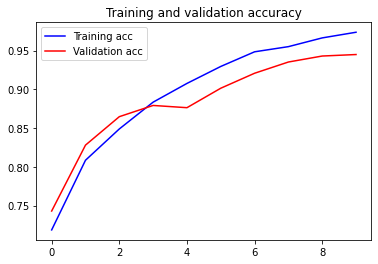

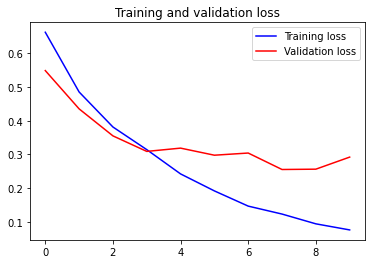

In [ ]:
import matplotlib.pyplot as plt

acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import r2_score

preds = model.predict(X_test)
r2_score(y_test, preds)

0.8156815030035105

In [ ]:
print(tokenizer.sequences_to_texts([X[-1]]), py[-1])

['<oov> <oov> in <oov> decreased by 10.5 % in <oov> , while sales outside <oov> dropped by 17 % .'] 0


* https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca
* https://medium.com/prosus-ai-tech-blog/finbert-financial-sentiment-analysis-with-bert-b277a3607101
* https://github.com/psnonis/FinBERT/blob/master/figs/analysis-001.jpg
* https://github.com/ProsusAI/finBERT/blob/master/notebooks/finbert_training.ipynb
* https://arxiv.org/pdf/1908.10063.pdf